- https://www.kaggle.com/code/rajmehra03/bike-sharing-demand-rmsle-0-3194

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import the necessary modelling algos.

#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification


# Global Variables

In [3]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/google_lecture/05. machine learning/Projects/kaggle/bike_sharing_demand/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'

args.submission_path = args.default_path+'sampleSubmission.csv'
args.submission_file = 'Submission_samples_{0:.5f}.csv'

args.SEED = 42
args.target = 'count'
args.numeric_cols = ['temp', 'atemp','humidity', 'windspeed']
args.category_cols = ['season', 'holiday', 'weather']

args.result_list = []

In [4]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [43]:
train=pd.read_csv(args.train_path)
test=pd.read_csv(args.test_path)

df=train.copy()
test_df=test.copy()
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<Axes: >

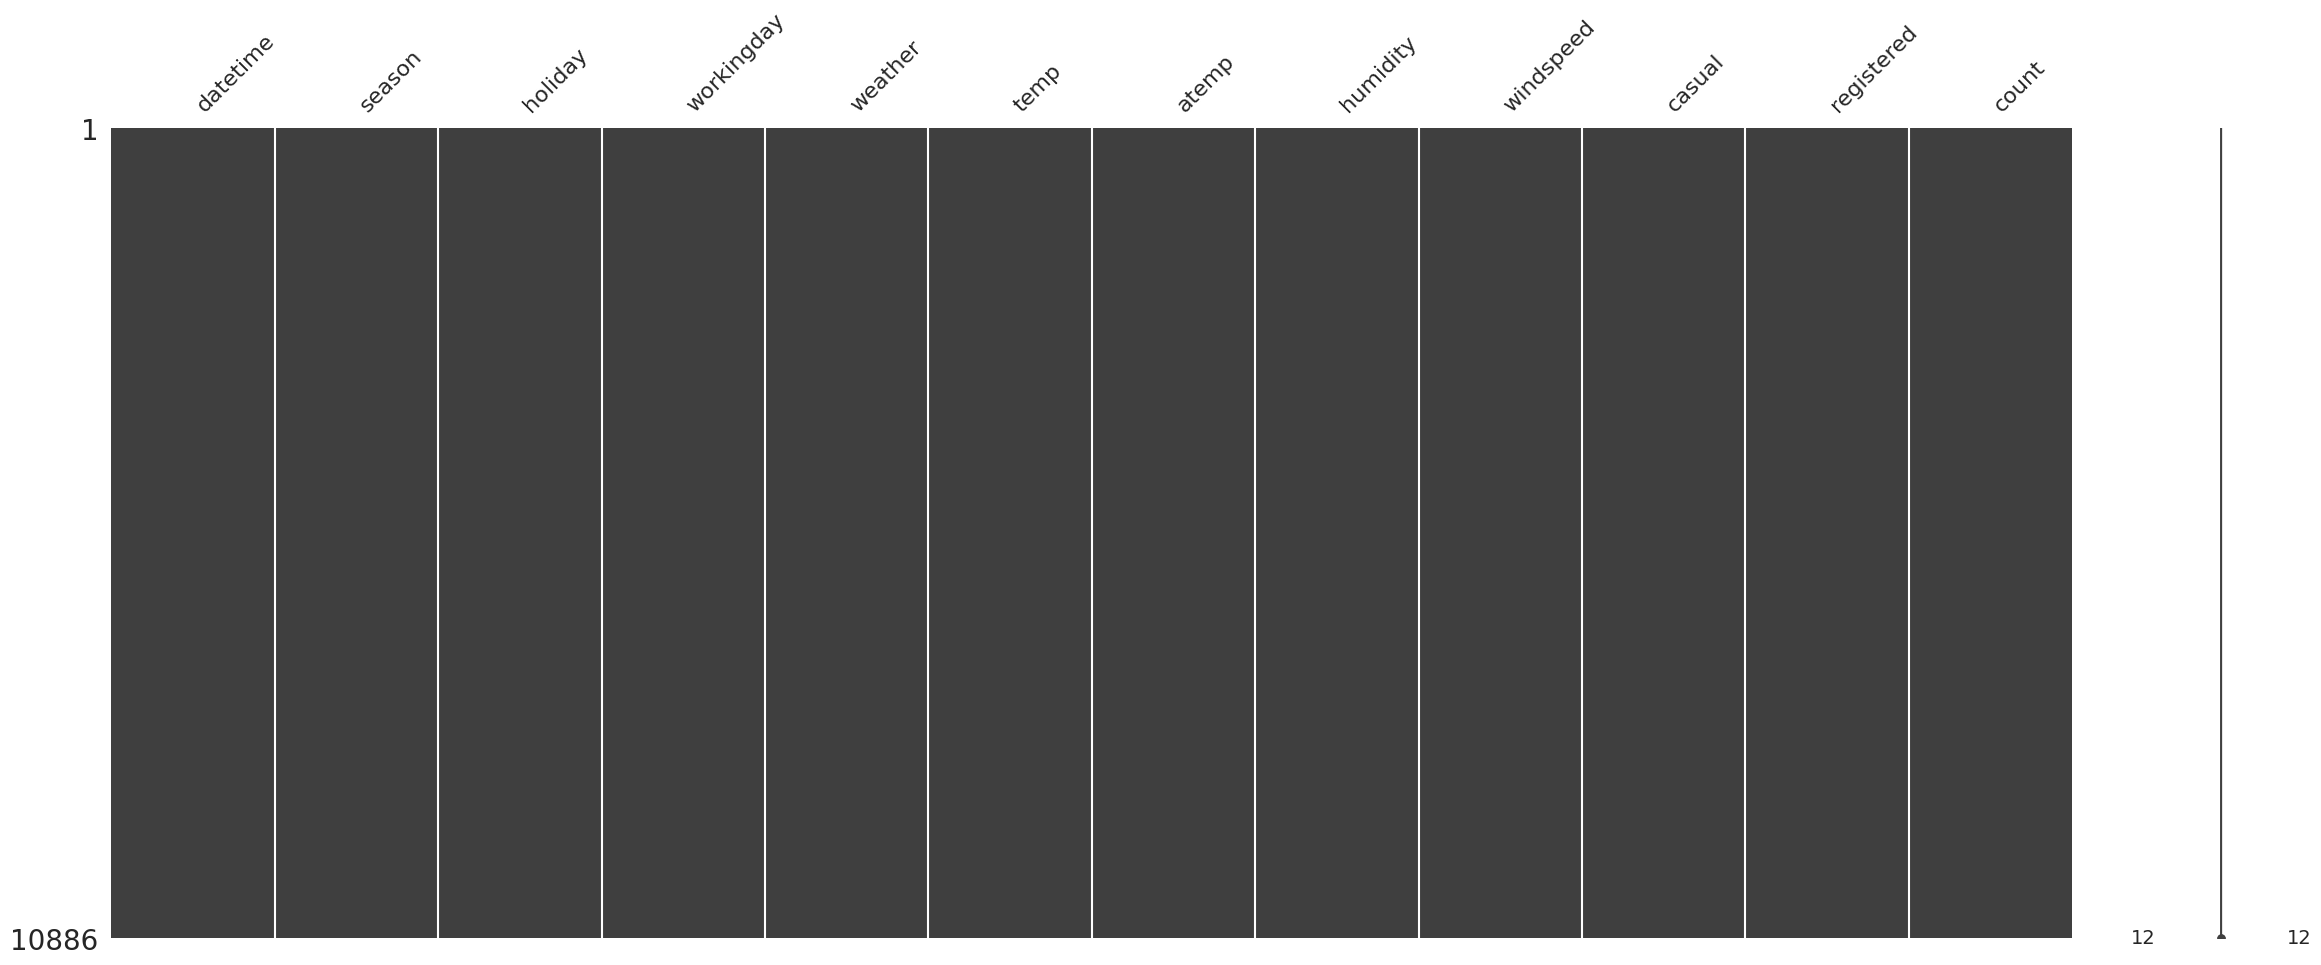

In [44]:
msno.matrix(df)  # just to visualize. no missing value.

In [45]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


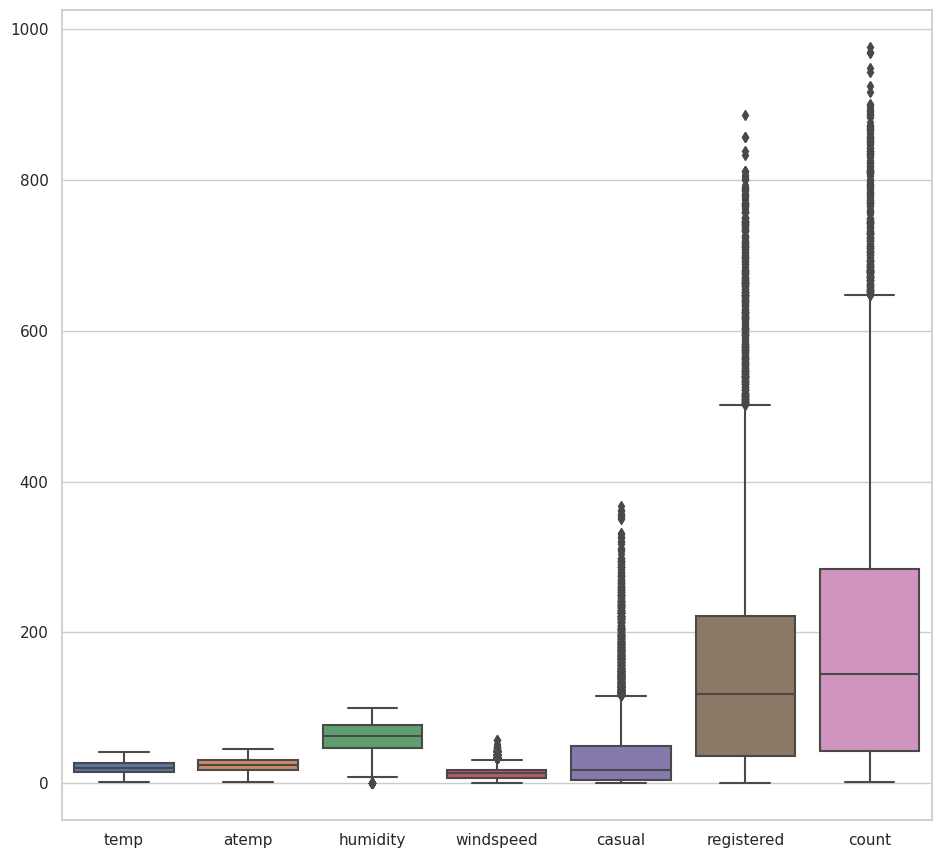

In [46]:
# just to visualize.
sns.boxplot(data=df[['temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']])
fig=plt.gcf()
fig.set_size_inches(10,10)

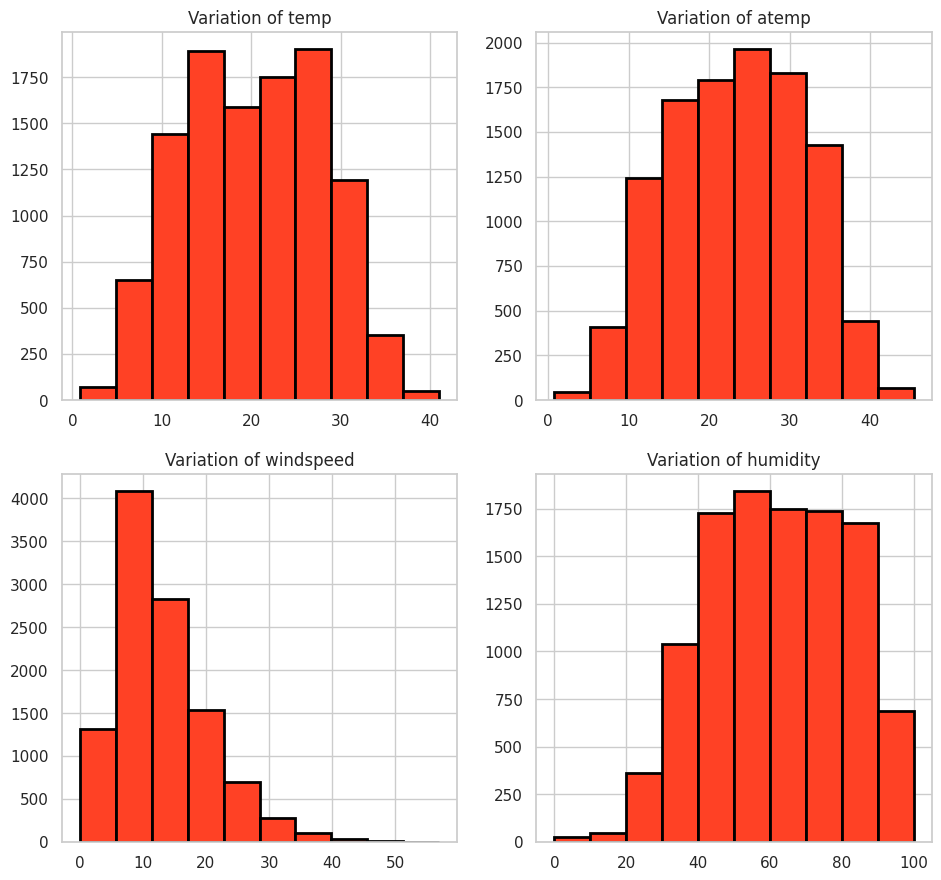

In [47]:
# can also be visulaized using histograms for all the continuous variables.
df.temp.unique()
fig,axes=plt.subplots(2,2)
axes[0,0].hist(x="temp",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("Variation of temp")
axes[0,1].hist(x="atemp",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("Variation of atemp")
axes[1,0].hist(x="windspeed",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("Variation of windspeed")
axes[1,1].hist(x="humidity",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("Variation of humidity")
fig.set_size_inches(10,10)

<Axes: >

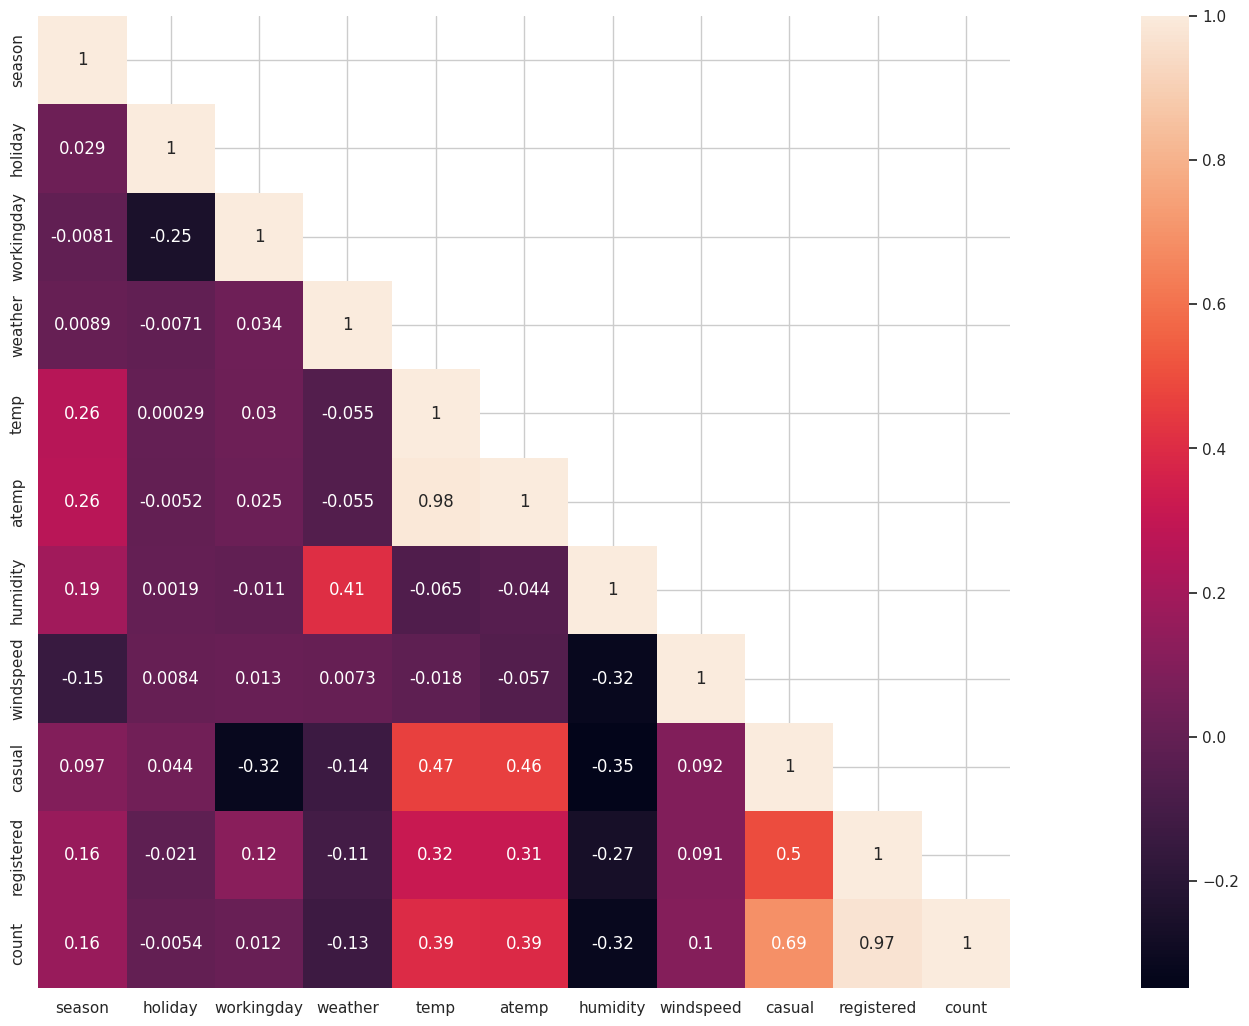

In [48]:
#corelation matrix.
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [49]:
# # seperating season as per values. this is bcoz this will enhance features.
season=pd.get_dummies(df['season'],prefix='season')
df=pd.concat([df,season],axis=1)
df.head()
season=pd.get_dummies(test_df['season'],prefix='season')
test_df=pd.concat([test_df,season],axis=1)
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0


In [50]:
# # # same for weather. this is bcoz this will enhance features.
weather=pd.get_dummies(df['weather'],prefix='weather')
df=pd.concat([df,weather],axis=1)
df.head()
weather=pd.get_dummies(test_df['weather'],prefix='weather')
test_df=pd.concat([test_df,weather],axis=1)
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0


In [51]:
# # # now can drop weather and season.
df.drop(['season','weather'],inplace=True,axis=1)
df.head()
test_df.drop(['season','weather'],inplace=True,axis=1)
test_df.head()


,datetime,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0


In [52]:
df["hour"] = [t.hour for t in pd.DatetimeIndex(df.datetime)]
df["day"] = [t.dayofweek for t in pd.DatetimeIndex(df.datetime)]
df["month"] = [t.month for t in pd.DatetimeIndex(df.datetime)]
df['year'] = [t.year for t in pd.DatetimeIndex(df.datetime)]
df['year'] = df['year'].map({2011:0, 2012:1})
df.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,...,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,...,0,0,1,0,0,0,0,5,1,0
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,...,0,0,1,0,0,0,1,5,1,0
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,...,0,0,1,0,0,0,2,5,1,0
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,3,10,13,...,0,0,1,0,0,0,3,5,1,0
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,0,1,1,...,0,0,1,0,0,0,4,5,1,0


In [53]:
test_df["hour"] = [t.hour for t in pd.DatetimeIndex(test_df.datetime)]
test_df["day"] = [t.dayofweek for t in pd.DatetimeIndex(test_df.datetime)]
test_df["month"] = [t.month for t in pd.DatetimeIndex(test_df.datetime)]
test_df['year'] = [t.year for t in pd.DatetimeIndex(test_df.datetime)]
test_df['year'] = test_df['year'].map({2011:0, 2012:1})
test_df.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0


# drop datetime

In [54]:
# now can drop datetime column.
df.drop('datetime',axis=1,inplace=True)
df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,season_1,...,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,3,13,16,1,...,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,8,32,40,1,...,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,5,27,32,1,...,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,3,10,13,1,...,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,0,1,1,1,...,0,0,1,0,0,0,4,5,1,0


<Axes: >

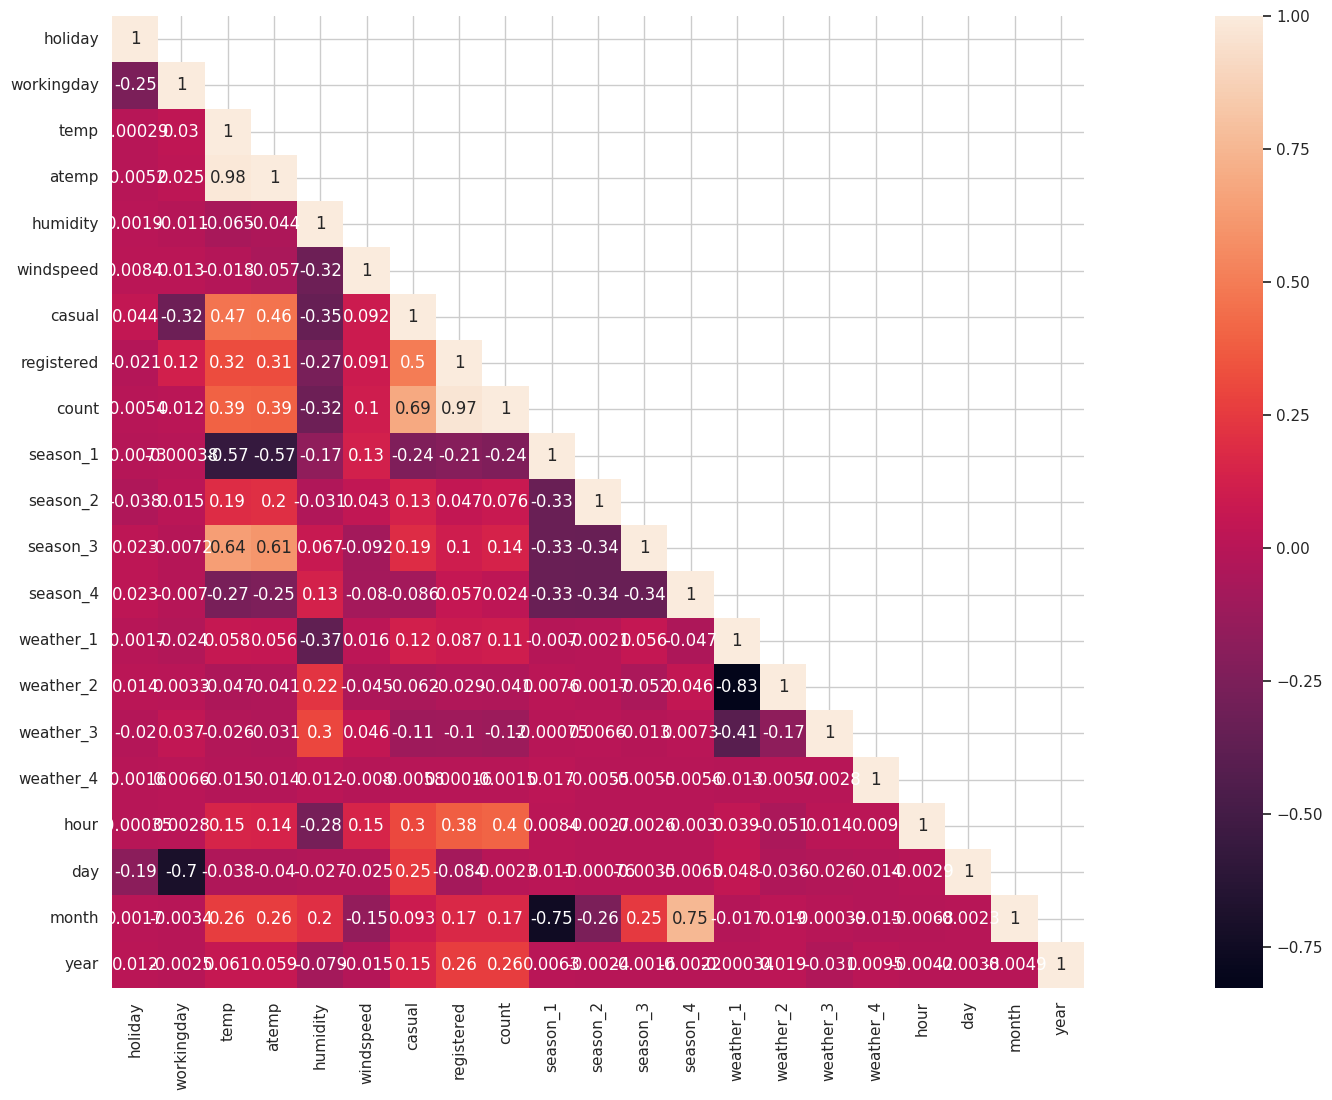

In [55]:
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [56]:
df.drop(['casual','registered'],axis=1,inplace=True)

In [57]:
df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,16,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,40,1,0,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,32,1,0,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,13,1,0,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,1,1,0,0,0,1,0,0,0,4,5,1,0


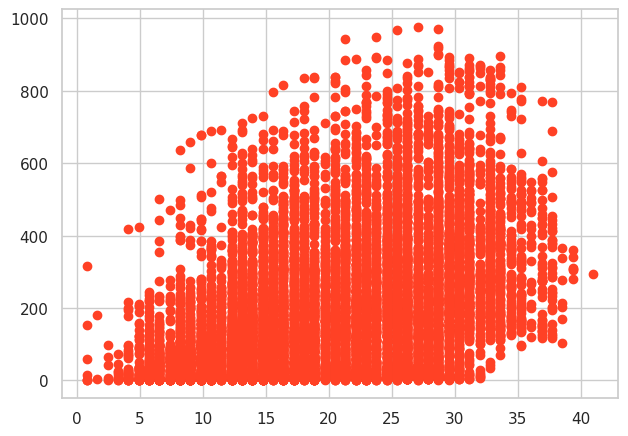

In [58]:
# for temp
plt.scatter(x="temp",y="count",data=df,color='#ff4125')

In [59]:
df.columns.to_series().groupby(df.dtypes).groups

{uint8: ['season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4'], int64: ['holiday', 'workingday', 'humidity', 'count', 'hour', 'day', 'month', 'year'], float64: ['temp', 'atemp', 'windspeed']}

In [60]:
x_train,x_test,y_train,y_test=train_test_split(df.drop('count',axis=1),df['count'],test_size=0.25,random_state=42)

In [61]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_test)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}
d

ValueError: ignored

In [ ]:
rmsle_frame=pd.DataFrame(d)
rmsle_frame